##Management Overview
The Osceola National Forest is an incredibly heavily managed ecosystem. Fire and mechanical thinning are combined to create what the managers think looks best, in spite of there being very few ecologically minded metrics to make such an assessment. However, the ecosystems are adapted for very frequent fire, with return intervals of fewer than 3 years in some locations. The driving force behind conducting these treatments is not really to mitigate intense disturbances such as extreme wildfire events, but rather to increase the harvest potential of the forest, by creating even age, single species stands. For soem reason, Palmetto reduction is one of those goals as well.

This study aims to understand current management practices, but more specifically, aims to understand the potential role management (prescribed fire and mechanical thinning) can have on mitigating the extreme fire weathe rdriven events that are becoming more frequent across the US.

To that end, this notebooks describes the modeling framework nuts and bolts required to build the Osceola management regions, design the treatments, and investigate the impact those treatments have on the underlying fire behavior model.

### Load required libraries

In [102]:
# Load required libraries and establish data directories

# ------- Notebook config
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

# ------- Load dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import gdal, os, osr
from scipy import stats
import random, ast, csv, math

# ------- Map dependencies
import fiona
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from descartes import PolygonPatch
from itertools import chain
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection

# ------- LANDIS Utilities
from NECN_utils import *
from DFFS_FBPS_utils import *
dataDir = 'Y:/DanK/Osceola/common/'

### Establishing management zones ...
for the Osceola JFSP project is sort of a tricky thing. First off, there are only two distinct differences in vegetation type: pine dominated and hardwood. The hardwood areas are never going to be treated, since they're exclusively in swampy regions. However, we do want to think about treating the areas that surround the swamps, to create a sort of buffer between the less frequent but more catastrophic fires that are typical of ignitions in the swampy regions.

### Lets take a look at our existing ecoregions
These are basically our baseline management regions. The basic strategy here is to create two version of the management zones: 1) don't buffer the swamps, 2) buffer the swamps by 2 pixels. Thats basically it.

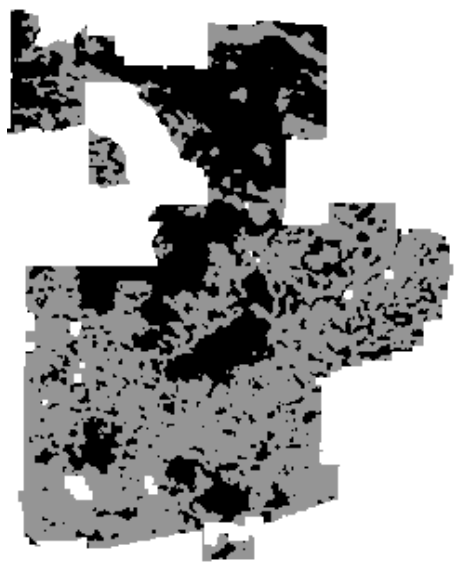

In [27]:
ecoR = importRaster(dataDir + 'Osceola_Ecoregions_150.tif')
f, (ax1) = plt.subplots(1,1, figsize = (10,10))
plotRaster(ecoR, ax = ax1)
sns.set_style('white')
sns.despine(left = True, bottom = True)

In [88]:
ecoR        = importRaster(dataDir + 'Osceola_Ecoregions_150.tif')
swmpBuffer1 = importRaster(dataDir + 'Osceola_Ecoregions_150.tif')
swmpBuffer2 = importRaster(dataDir + 'Osceola_Ecoregions_150.tif')

height, width = ecoR.shape

for row in range(0,height):
    for col in range(0,width):
        if 2 in cell_neighbors(swmpBuffer1, row, col, 1):
            swmpBuffer1[row,col] = 3

for row in range(0,height):
    for col in range(0,width):
        if 3 in cell_neighbors(swmpBuffer1, row, col, 1):
            swmpBuffer2[row,col] = 3 

# Create a new version of the management layer
# This is nice and easy, 0 and 1 stay the same. 
# swamp becomes 6, buffer becomes 3.
mgmtLayers = ecoR * swmpBuffer2

# Write the IC raster to file as well
saveAsGeoTiff(dataDir + 'Osceola_Ecoregions_150.tif', mgmtLayers,
              dataDir + 'Osceola_MGMT.tif', 26917)

array([ 0.,  1.,  3.,  6.])

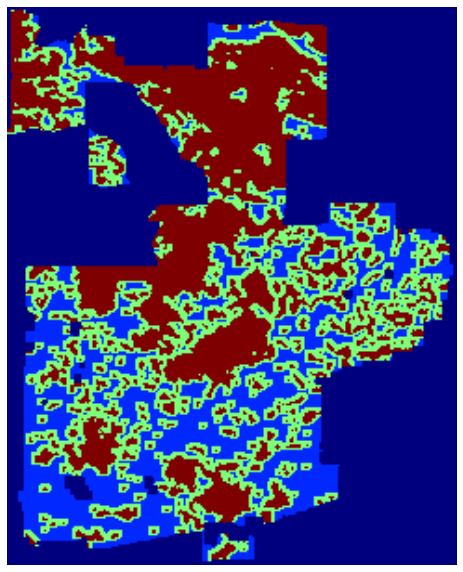

In [89]:
f, (ax1) = plt.subplots(1,1, figsize = (10,10))
plotRaster(mgmtLayers, ax = ax1, cmap = 'jet')
np.unique(mgmtLayers)

In [100]:
def genStandMap(src_dir, base_map_name, stands_map_name):
    # Load in the IC file
    baseMapPath = src_dir + base_map_name
    src_ds = gdal.Open( baseMapPath )
    baseMap = src_ds.ReadAsArray()

    # Create an 'inactive' mask from the 0 values in the IC map
    baseMap[baseMap > 0] = 1

    # Get dimensions for stand map, create a raster with values
    # that range from 1 - the number of cells
    rows = int(baseMap.shape[0])
    cols = int(baseMap.shape[1])
    cellID = np.arange(rows * cols)
    cellID = cellID.reshape(rows,cols) + 1

    # Apply the binary mask
    standMap = cellID * baseMap

    # Get a geotiff driver and write the raster
    driver = gdal.GetDriverByName('GTiff')
    ds = driver.Create(src_dir + stands_map_name,
                   cols, rows, 1, gdal.GDT_Int32)
    ds.GetRasterBand(1).WriteArray(standMap)
    ds.FlushCache()

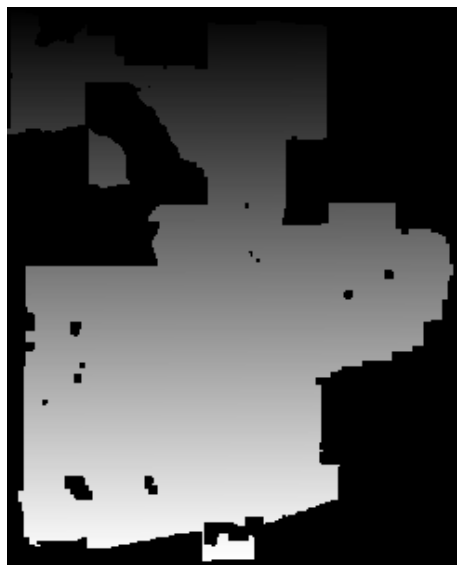

In [99]:
genStandMap(dataDir, 'Osceola_Ecoregions_150.tif', 'OsceolaStands.tif')
osceolaStands = importRaster(dataDir + 'OsceolaStands.tif')
f, (ax1) = plt.subplots(1,1, figsize = (10,10))
plotRaster(osceolaStands, ax = ax1, cmap = 'gray')